# Titanic 4: Tuning the whole pipeline with Cross Validation

In this notebook we will see how Grid Search Cross Validation can be used to not only tune the parameters of the model but also the parameters of all the transformers in a pipeline, thus helping us find the best preprocessing strategy for our data.

## 1. Pipeline creation

As shown in the previous notebooks, here we clean the data, split it and create a pipeline:

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

# reading
data =df = pd.read_csv("housing-classification-iter-0-2.csv") #reading data from csv
data.shape

# X and y creation
X = data
y = X.pop("Expensive")

# feature selection: only numericals
X_num = X.select_dtypes(include="number").copy()

# data splitting
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=31416)

# initialize transformers &amp; model
imputer = SimpleImputer()
dtree = DecisionTreeClassifier()
 
# Create a pipeline
pipe = make_pipeline(imputer,
                     dtree)


## 2. Cross Validation with the whole pipeline:

We can see the steps in the pipeline (note that they have been given names: `simpleimputer` and `decisiontreeclassifier`. we will use these names when defining the parameter grid for the cross validation)

In [20]:
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

To define the parameter grid for cross validation, you need to create a dictionary, where:

- The keys are the name of the pipeline step, followed by two underscores and the name of the parameter you want to tune.
- The values are lists (or "ranges") with all the values you want to try for each parameter.

In [21]:
param_grid = {
    "simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 12),
    "decisiontreeclassifier__min_samples_leaf": range(3, 10),
    "decisiontreeclassifier__criterion":["gini", "entropy"]
}

When defining the cross validation, we want to pass our pipeline (`pipe`), our parameter grid (`param_grid`) and the number of folds (an arbitrary number, usually 5 or 10). You can also define the parameter `verbose` if you want to recieve a bit more info about the CV task.

In [22]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe,
                      param_grid,
                      cv=10,
                      verbose=1)

Fit your "search" to the training data (`X` and `y`), as we used to do with our model alone or with our pipeline:

In [23]:
search.fit(X_num_train, y_train)

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(2, 12),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 10),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

Explore the best parameters and the best score achieved with your cross validation:

In [24]:
search.best_params_

{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 3,
 'simpleimputer__strategy': 'median'}

In [25]:
# cross validation average accuracy
search.best_score_

0.929804008252284

In [26]:
# training accuracy
y_train_pred = search.predict(X_num_train)

train_accuracy= accuracy_score(y_train, y_train_pred)

round(train_accuracy, 2)

0.94

In [27]:
# testing accuracy
y_test_pred = search.predict(X_num_test)

test_accuracy= accuracy_score(y_test, y_test_pred)

round(test_accuracy, 2)

0.93

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix= confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None, normalize=None)
confusion_matrix

array([[244,  10],
       [ 11,  27]], dtype=int64)

In [31]:
from sklearn.metrics import classification_report

classification_report(y_test, y_test_pred,labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')

'              precision    recall  f1-score   support\n\n           0       0.96      0.96      0.96       254\n           1       0.73      0.71      0.72        38\n\n    accuracy                           0.93       292\n   macro avg       0.84      0.84      0.84       292\nweighted avg       0.93      0.93      0.93       292\n'

In [33]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       254
           1       0.73      0.71      0.72        38

    accuracy                           0.93       292
   macro avg       0.84      0.84      0.84       292
weighted avg       0.93      0.93      0.93       292



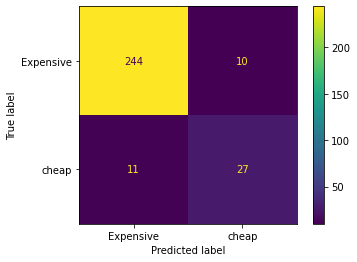

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

display= ConfusionMatrixDisplay(confusion_matrix,display_labels=['Expensive','cheap'])
display.plot()
plt.show()

## **Exercise 1:**

Add a scaler to the pipeline, and use GridSearchCV to tune the parameters of the scaler, as well as the parameters of the imputer and the decision tree.

In [10]:
# Solution:
from sklearn.preprocessing import StandardScaler

# initialize transformers &amp; model
imputer = SimpleImputer()
scaler = StandardScaler()
dtree = DecisionTreeClassifier()

# create the pipeline
pipe = make_pipeline(imputer,
                     scaler,
                     dtree)

# create parameter grid
param_grid = {
    "simpleimputer__strategy":["mean", "median"],
    "standardscaler__with_mean":[True, False],
    "standardscaler__with_std":[True, False],
    "decisiontreeclassifier__max_depth": range(2, 12),
    "decisiontreeclassifier__min_samples_leaf": range(3, 10),
    "decisiontreeclassifier__criterion":["gini", "entropy"]
}

# define cross validation
search = GridSearchCV(pipe,
                      param_grid,
                      cv=10,
                      verbose=1)

# fit
search.fit(X_num_train, y_train)

# cross validation average accuracy
search.best_score_

Fitting 10 folds for each of 1120 candidates, totalling 11200 fits


0.9289493073975834

In [11]:
# best parameters
search.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 6,
 'simpleimputer__strategy': 'mean',
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True}